<a href="https://colab.research.google.com/github/mlukan/GDA3B2021/blob/main/NN/RNN_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Setting up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import expit as sigmoid

# Make Jupyter output multiple results without explicit print statements (see https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Recurrent Neural Networks

We will be focusing on the task of figuring out  $p(x_{t}|x_{t−1},…x_{1}) $, where $t$ specifies the order of observations. The order could be implied by time (what is the value of x in the future, given the past values of x) or syntax (what's the next word in a sentence starting with words x,y and z).

Today we will try to see how NN architecture can be re-assembled to accomodate this task.


**Outline**
1. Sequential data
2. Recurrent cells and networks


## 1. Sequential data
We discuss some of the peculiarities of sequential data and how to address them during data preparation. Our use case will be stock market data. 

### Load the data
Financial data (at a daily level) is publicly available online. The data for this excercise was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/AMZN/history?p=AMZN) but many other sources exist. You can download the data yourself to benefit from the most recent set of data or simply use the [data set in the WCS github](https://raw.githubusercontent.com/crajapax/GDAtrack3b/main/AMZN.csv). Clearly, you can also change the subject of analysis. We look at Amazon stock prices but any other stock - or time series - will do.

In [4]:
# Load dataset and set app name as index
path="https://raw.githubusercontent.com/crajapax/GDAtrack3b/main/AMZN.csv"


In [5]:
data = pd.read_csv(path)
#set the date as the index of our dataframe, ie. each of our datapoints (stock prices) correspond to a date
data.set_index('Date', inplace=True)
# This is the first time we deal with time series data. Using the date as index is useful for subsetting. Subsetting a data frame is the process of selecting a set of desired rows and columns from the data frame
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-24,1951.500000,1955.000000,1900.339966,1940.099976,1940.099976,7147100
2020-03-25,1920.689941,1950.260010,1885.780029,1885.839966,1885.839966,6479100
2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6115100


In [6]:
# We only need the adjusted closing price
data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
data.columns = ['Price']
data.head()

,Price
Date,
2009-03-31,73.440002
2009-04-01,73.500000
2009-04-02,76.339996
2009-04-03,78.169998
2009-04-06,77.989998


In [7]:
data.tail()

,Price
Date,
2020-03-24,1940.099976
2020-03-25,1885.839966
2020-03-26,1955.489990
2020-03-27,1900.099976
2020-03-30,1963.949951


In [8]:
data.shape

(2769, 1)

In [9]:
data.index.values

array(['2009-03-31', '2009-04-01', '2009-04-02', ..., '2020-03-26',
       '2020-03-27', '2020-03-30'], dtype=object)

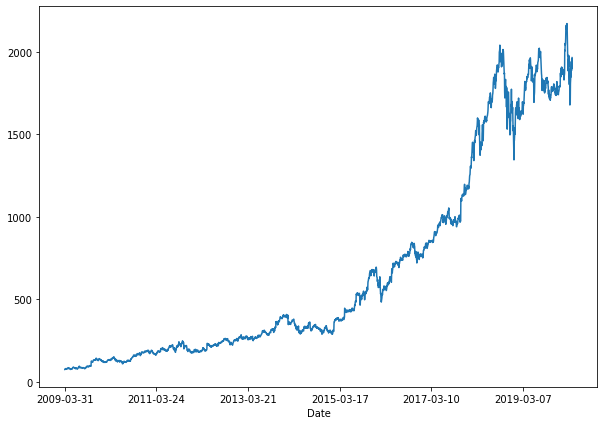

In [ ]:
data.Price.plot(figsize = (10, 7))

### Preparing sequential data
Let's try to see what RNN can do with some financial data. We take the stock price of Amazon for the past 2 years from Yahoo Finance. 
We will ignore other available information, like the stock price of other e-commerce companies or tax rates in Ireland. Our data is thus a single variable, the stock price. While we move through time, we predict the price in the next period based on the previous periods' prices. We then move one period ahead and the actual price of last period becomes a new observation. 

$$ 
\widehat{price_t} = f(price_{t-1},price_{t-2},price_{t-3},price_{t-4},\ldots) 
$$

We can see a clear trend in the data of the share price increasing over time. That's easy for our model to pick up and not very informative, so we better standardize the mean price over time. Instead of the overall price, we will predict the price difference from today to tomorrow's closing price. 
Pandas knows a the function *.shift()*. Have a look at its [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html). This function is what we need to calculate price differences.

In [10]:
data["Price"] = (data["Price"] - data["Price"].shift(1))

In [11]:
# The previous shift causes the first entry in our dataframe to be NaN
data.head(3)

,Price
Date,
2009-03-31,NaN
2009-04-01,0.059998
2009-04-02,2.839996


In [12]:
# Make sure you understand where the NaN value is coming from
# To get rid of it, we discard the first entry
data = data.iloc[1:,:]
print('Original dimension: ' + 'x'.join(map(str,data.shape)))
print('New dimension: ' + 'x'.join(map(str,data.shape)))

Original dimension: 2768x1
New dimension: 2768x1


<AxesSubplot:xlabel='Date'>

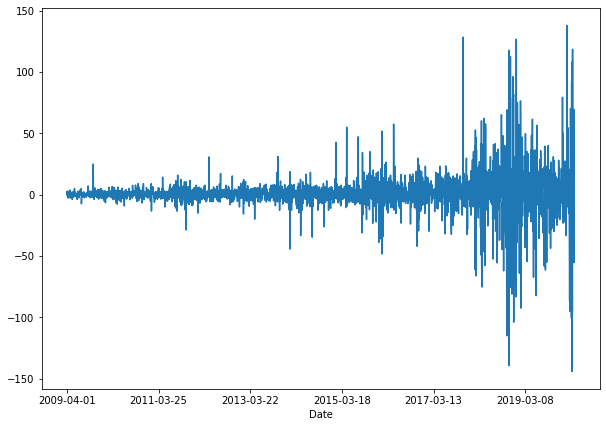

In [13]:
# Plot series of price differences (i.e., returns)
data.Price.plot(figsize = (10, 7))

There is more preprocessing we could/should do. Look into
classes on[ time-series forecasting](https://medium.com/data-science-in-your-pocket/preprocessing-for-time-series-forecasting-3a331dbfb9c2/).

To evaluate the model and potential overfitting, we want a train/test split. 
Remember that our observations have a time structure now - no shuffling, strictly use observations from the future for testing! With that in mind, there really is no need to involve scikit-learn for data organization.

In [14]:
train_size  = int(len(data) * 0.80)
test_size   = len(data) - train_size
train, test = data[:train_size], data[train_size:]

In [16]:
train.shape,test.shape

((2214, 1), (554, 1))

In [ ]:
train_size

2214

We will apply the usual preprocessing to standardize the input data. 

In [17]:
#Data preparation (can be skipped)

# Convert data to numpy array.
# The conversion will alter the dimension. We redo this with the rescaling 
 # note that the -1 means that the dimension of the axis will be inferred from the data
train["Price"].to_numpy().reshape([-1,1])

array([[ 0.059998],
       [ 2.839996],
       [ 1.830002],
       ...,
       [22.350098],
       [28.519897],
       [-0.339966]])

In [18]:
#It is equivalent to inputting the number of rows (i.e., train_size) as argument (=train["Price"].to_numpy().reshape([train_size,1]) )
train["Price"].to_numpy().reshape([train_size,1])

array([[ 0.059998],
       [ 2.839996],
       [ 1.830002],
       ...,
       [22.350098],
       [28.519897],
       [-0.339966]])

In [19]:
 # note that the -1 means that the dimension of the axis will be inferred from the data
train = train["Price"].to_numpy().reshape([-1,1])
test = test["Price"].to_numpy().reshape([-1,1]) # in plain English, it is equivalent to inputting the number of rows (i.e., train_size) as argument (=train["Price"].to_numpy().reshape([train_size,1]) )
from sklearn.preprocessing import MinMaxScaler
#Normalize the values to a range from zero to 1
#Note the proper application of the scaler: fitting parameters on train and apply these to test
#This is the standart procedure to scale. You always learn your scaling parameters on the train and then use them on the test. Otherwise you incorporate information from test data into the training process.
# This article explains it very well:https://sebastianraschka.com/faq/docs/scale-training-test.html
scaler = MinMaxScaler()
train  = scaler.fit_transform(train)
test   = scaler.transform(test)

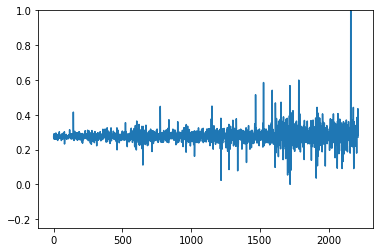

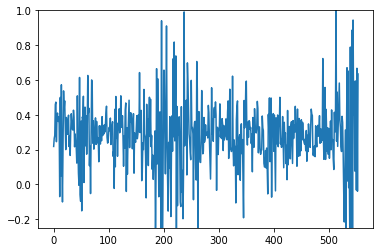

In [20]:
plt.ylim([-0.25,1])
plt.plot(train)
plt.show()  ;

plt.ylim([-0.25,1])
plt.plot(test)
plt.show();

The data is almost ready for developing a forecasting model. What is missing? 
We are tryting to build an autoregressive model, which uses past realizations of the target variable as input to predict the next realization of the target variable.
So the following bits help us create the input data structure for such a model. With a window size we define how much past data observation we take to make the prediction of our next observation.
So we suppose every next step of a time series is the function of n (= window size) previous steps: and the influence of the rest time series members is negligible small. The chosen number n is called the window size.


In [21]:
# this function gets the time series x as input and a window size and returns the Input Data Structure for Test and Train
def create_dataset(time_series, window_size):
    """ Function to create data set with lagged response values for estimating an autoregressive model"""
    dataX, dataY = [], []
    
    for i in range(0,len(time_series) - window_size - 1):
        x = time_series[i:i + window_size] # Remember: x[a:b-1]
        dataX.append(x)
        y = time_series[i + window_size] # Remember: x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

In [22]:
# we set a window size of 22
WINDOW_SIZE=22

X_train, y_train  = create_dataset(train, WINDOW_SIZE)
X_test, y_test   = create_dataset(test, WINDOW_SIZE)
print (X_train.shape)
print (y_train.shape)

(2191, 22, 1)
(2191, 1)


In [23]:
# NOTICE the first observation input is constructed from train index 0 to 21
#the first observation label from train index 22 
# second obersvation input constrcted from train index 1 to 22
#the second observation label constructed from train index 23 
# third observation input constructed from train index 2 to 23,  the third observation label constructed from train index 24,  .....

#the first 22 elements constitute our our first datapoint in, ie. row in X_train, and the element 23 the label
train[0:23,0]


array([0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
       0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
       0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
       0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
       0.27749189, 0.26454456, 0.27794421])

In [24]:
#this is the datapoint label belonging to the first datapoint 
train[22,0]

0.27794420955683713

In [ ]:
#check it out in X_train and y_train
X_train[0]

array([[0.27370381],
       [0.28942156],
       [0.28371118],
       [0.27234689],
       [0.259343  ],
       [0.28167578],
       [0.28913885],
       [0.2686719 ],
       [0.26363992],
       [0.25917335],
       [0.28772543],
       [0.2778877 ],
       [0.27065071],
       [0.2799796 ],
       [0.27596536],
       [0.28133657],
       [0.29513198],
       [0.26578842],
       [0.26929379],
       [0.25860797],
       [0.27749189],
       [0.26454456]])

In [ ]:
#this is the datapoint label belonging to the first datapoint 
y_train[0]

array([0.27794421])

Again, note how feature values are shifted by one period between one observation and the next observation. 

In [ ]:
X_train.shape

(2191, 22, 1)

In [ ]:
X_train[0:3,:,0]

array([[0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
        0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
        0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
        0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
        0.27749189, 0.26454456],
       [0.28942156, 0.28371118, 0.27234689, 0.259343  , 0.28167578,
        0.28913885, 0.2686719 , 0.26363992, 0.25917335, 0.28772543,
        0.2778877 , 0.27065071, 0.2799796 , 0.27596536, 0.28133657,
        0.29513198, 0.26578842, 0.26929379, 0.25860797, 0.27749189,
        0.26454456, 0.27794421],
       [0.28371118, 0.27234689, 0.259343  , 0.28167578, 0.28913885,
        0.2686719 , 0.26363992, 0.25917335, 0.28772543, 0.2778877 ,
        0.27065071, 0.2799796 , 0.27596536, 0.28133657, 0.29513198,
        0.26578842, 0.26929379, 0.25860797, 0.27749189, 0.26454456,
        0.27794421, 0.28540736]])

In [ ]:
y_train

array([[0.27794421],
       [0.28540736],
       [0.27387341],
       ...,
       [0.28258042],
       [0.39972918],
       [0.43461244]])

In [ ]:
#lets check out teh last 3 datapoints and last three labels
X_train[-3:,:,0]

array([[0.31542975, 0.28585942, 0.31248963, 0.25165322, 0.26799368,
        0.33063834, 0.30095551, 0.33804455, 0.25527247, 0.21818274,
        0.25719459, 0.23717966, 0.32085725, 0.30446088, 0.29507526,
        0.17934066, 0.38384147, 0.35924657, 0.30383904, 0.38389806,
        0.37360763, 0.30632641],
       [0.28585942, 0.31248963, 0.25165322, 0.26799368, 0.33063834,
        0.30095551, 0.33804455, 0.25527247, 0.21818274, 0.25719459,
        0.23717966, 0.32085725, 0.30446088, 0.29507526, 0.17934066,
        0.38384147, 0.35924657, 0.30383904, 0.38389806, 0.37360763,
        0.30632641, 0.28258042],
       [0.31248963, 0.25165322, 0.26799368, 0.33063834, 0.30095551,
        0.33804455, 0.25527247, 0.21818274, 0.25719459, 0.23717966,
        0.32085725, 0.30446088, 0.29507526, 0.17934066, 0.38384147,
        0.35924657, 0.30383904, 0.38389806, 0.37360763, 0.30632641,
        0.28258042, 0.39972918]])

In [ ]:
y_train[-3:]

array([[0.28258042],
       [0.39972918],
       [0.43461244]])

Let us verify the sequential pattern in our data. To that end, we first append our target variable as a new column (after performing some reshaping to make that operation possible) and output a couple of values. 

In [ ]:
X_train.shape

(2191, 22, 1)

In [ ]:
y_train.shape

(2191, 1)

In [ ]:
print(y_train.reshape([-1,1,1]).shape)
y_train.reshape([-1,1,1])

(2191, 1, 1)


array([[[0.27794421]],

       [[0.28540736]],

       [[0.27387341]],

       ...,

       [[0.28258042]],

       [[0.39972918]],

       [[0.43461244]]])

In [ ]:
# Append the target variable to our array as a new column!! 
np.hstack([X_train, y_train.reshape([-1,1,1])])[0:10,:,0]

array([[0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
        0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
        0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
        0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
        0.27749189, 0.26454456, 0.27794421],
       [0.28942156, 0.28371118, 0.27234689, 0.259343  , 0.28167578,
        0.28913885, 0.2686719 , 0.26363992, 0.25917335, 0.28772543,
        0.2778877 , 0.27065071, 0.2799796 , 0.27596536, 0.28133657,
        0.29513198, 0.26578842, 0.26929379, 0.25860797, 0.27749189,
        0.26454456, 0.27794421, 0.28540736],
       [0.28371118, 0.27234689, 0.259343  , 0.28167578, 0.28913885,
        0.2686719 , 0.26363992, 0.25917335, 0.28772543, 0.2778877 ,
        0.27065071, 0.2799796 , 0.27596536, 0.28133657, 0.29513198,
        0.26578842, 0.26929379, 0.25860797, 0.27749189, 0.26454456,
        0.27794421, 0.28540736, 0.27387341],
       [0.27234689, 0.259343  , 0.28167578, 0.289

Since we have only one feature variable, the price of the Amazon stock, our data fits into a 2D array. The column dimension of such an array stores the **different lags of our (single) feature variable.**
The row dimension represents **different observations or points in time**. Here is an example:





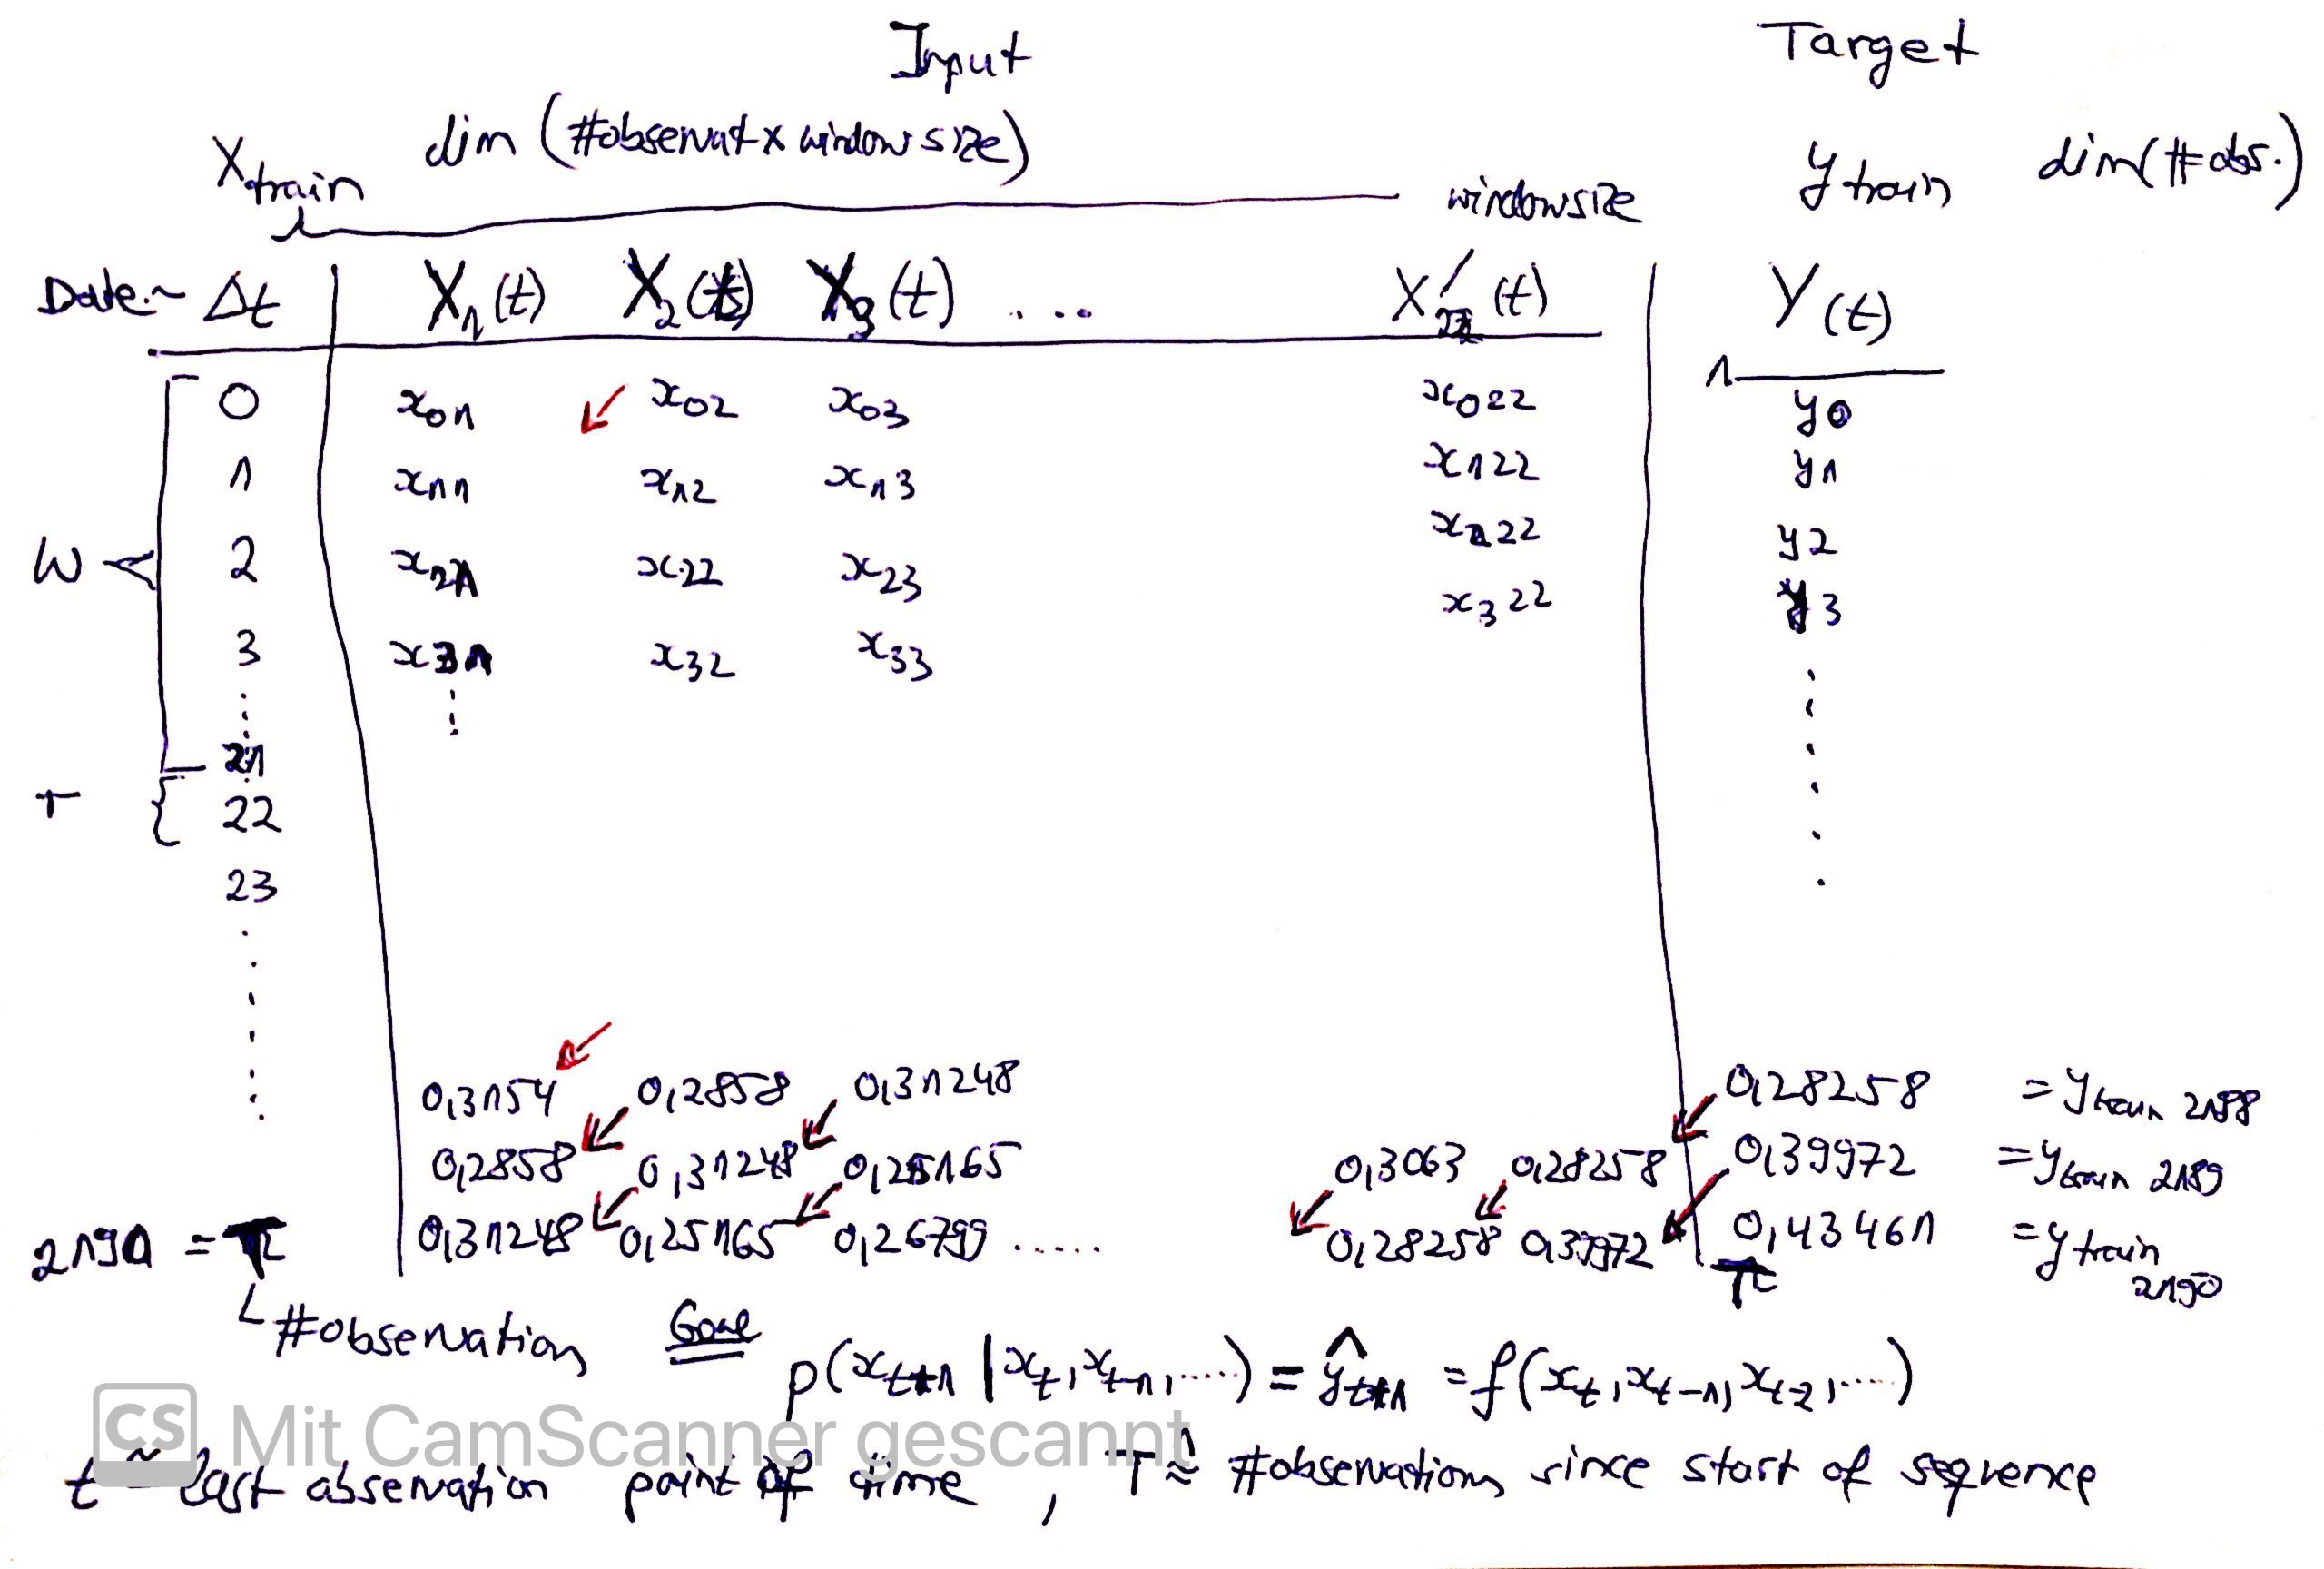

If we had **additional variables, each with a time stamp of its own, we would need a 2D table for each variable or put them into a 3D array** [observations, time periods, features]. This is what tensorflow expects, so we'll reshape our 2D data to conform with the more general 3D case.

In [ ]:
#Reshape input to be [samples, time steps, features]
X_train  = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
X_test   = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)
#Train set ended up with 1789 samples, 22 obs each and 1 feature

(2191, 22, 1) (2191, 1) (531, 22, 1) (531, 1)


The value **22, which was our _window size_** is probably the part most difficult to grasp. In a nutshell, we feed our RNN with subsets or slices of our time series. The **window size determines the size of one such slice**. We then **interpret one slice as one observation**, which resembles the non-recurrent, feedforward neural networks we considered before. There, one observation was something like one client or borrower, who was characterized by $m$ feature values. RNNs extend that idea. **For each feature, we have a time series of which we feed the network slices**. Let's examine this in more detail.

<img src="https://drive.google.com/uc?id=1Fl1UI4RE2LtIWhE5FyA3niF5XeELpGta" width="600px"/>

## Recurrent cells and networks


Let's assume we have trained the network so that good values for the matrices $W_{in}$ and $W_h$ and the biases $b_{in}$ and $b_h$ are available. We will calculate a forward pass for a single observation 'by hand' in numpy, to be able to follow the process. 

In [ ]:
# Dimension of hidden state
NO_STATE_NODES = 5
#Number of features. We are using a univariate time series, so the input dimension is 1
INPUT_DIM = 1
# Number of output variables that we want to predict.
NO_OUTPUT_NODES = 1
# Number of observations we process together 
BATCH_SIZE = 1

In [ ]:
W_in  = np.random.randn(INPUT_DIM, NO_STATE_NODES) 
W_h   = np.random.randn(NO_STATE_NODES, NO_STATE_NODES)
W_out = np.random.randn(NO_STATE_NODES, NO_OUTPUT_NODES) 

b_in  = np.random.randn(1, NO_STATE_NODES) 
b_h   = np.random.randn(1, NO_STATE_NODES) 
b_out = np.random.randn(1, NO_OUTPUT_NODES)

Remember: The input matrix is the matrix of weights from the single input $x_t$ to NO_STATE_NODES hidden nodes. 

In [ ]:
W_in

array([[-0.31472154, -0.2239392 , -0.11615024, -0.01797951, -0.44066356]])

The hidden state transformation matrix is the matrix that transforms the **previous hidden state and new input to the new hidden state, both of dimension NO_STATE_NODES.**

In [ ]:
W_h

array([[ 0.12937936, -0.16999787,  1.33316636, -1.33227872, -1.09544347],
       [-0.84574753,  1.41218617,  0.41089409,  0.23505614, -0.56087962],
       [-0.91430928, -0.88484523, -0.29492537,  1.56215356, -1.22100169],
       [ 0.45654663, -0.93244949,  0.873514  ,  1.14675764, -0.48667935],
       [-0.61163945,  0.12599377, -0.65556223,  0.13621617,  0.59704999]])

Since we haven't seen any input, we have not yet calculated a hidden state. We **initialize the hidden state to 0**.

In [ ]:
h_state = np.zeros([BATCH_SIZE, NO_STATE_NODES])
h_state

array([[0., 0., 0., 0., 0.]])

Training begins by drawing a **minibatch of size BATCH_SIZE** (=1), where **each row contains an ordered piece of the overall time series** over INPUT_DIM (one or more) variables. In financial forecasting context, for example, you could try to predict the daily closing price of a stock at day $t+1$, $x_{t+1}$, from the **five previous closing prices of that stock**. So your **input sequence** is $\left(x_{t-4}, x_{t-3}, ..., x_t \right)$, and this **corresponds to one row in your input data**. 
Remember that we have previously set the number of **past realizations of our input variable, the window size, to 22.**

In [ ]:
# Always pay attention to dimensions...
print('Dimension of the training data (samples, window size, features) :' , 'x'.join(map(str,X_train.shape)))
minibatch = X_train[0:BATCH_SIZE,:,:]
print('Dimension of our minibatch :' , 'x'.join(map(str,minibatch.shape)))
minibatch = minibatch.reshape([-1, WINDOW_SIZE])
print('Corrected minibatch dimension:' , 'x'.join(map(str,minibatch.shape)))

#our first input sequence corresponds to one row in our input data
minibatch

Dimension of the training data (samples, window size, features) : 2190x22x1
Dimension of our minibatch : 1x22x1
Corrected minibatch dimension: 1x22


array([[0.28942156, 0.28371118, 0.27234689, 0.259343  , 0.28167578,
        0.28913885, 0.2686719 , 0.26363992, 0.25917335, 0.28772543,
        0.2778877 , 0.27065071, 0.2799796 , 0.27596536, 0.28133657,
        0.29513198, 0.26578842, 0.26929379, 0.25860797, 0.27749189,
        0.26454456, 0.27794421]])

### First input

We then **update the hidden state using our 'first' observation from t-WINDOW SIZE**. More specifically, we first process the input according to: <br><br>$ \textrm{processed input} = W_{in} \vec{x_{t}}+\vec{b_{in}} $

In [ ]:
minibatch[:,0]

array([0.27370381])

In [ ]:
first_input = minibatch[:,0:1] # in case you stumble upon the second index and would rather use 0 instead of 0:1, compare the shape of the results to see why we do it this way

In [ ]:
first_input

array([[0.27370381]])

In [ ]:
W_in

array([[-2.42842639, -0.35010508, -1.31354894,  1.21133385, -0.60183415]])

In [ ]:
b_in

array([[ 0.32977186,  0.02761764, -0.82154198,  1.43103304, -2.52112913]])

In [ ]:
proc_input = np.dot(first_input, W_in) + b_in

In [ ]:
print('Processed input:' , 'x'.join(map(str,proc_input.shape)))
proc_input

Processed input: 1x5


array([[-0.57427776, -1.21897043, -0.64081603, -0.91870643,  0.52742064]])

... and use the result to **update the hidden state** <br>

$\vec{h_t} = tanh \left( W_{h} \vec{h_{t-1}}  + \textrm{processed input} + \vec{b_{h}} \right)$

In [ ]:
h_state_new = np.tanh( np.dot(h_state, W_h) + proc_input + b_h )
h_state_new

array([[-0.65699513, -0.87826072,  0.02063427, -0.55494431, -0.29328808]])

In [ ]:
h_state

array([[0., 0., 0., 0., 0.]])

In [ ]:
h_state = h_state_new

The **new values of the hidden state make up our memory of the first observation**. 

### Second input

We then update the **hidden state given the next observation from t-21**; **re-using the input weights that we used for the first observation**. Remember, in an RNN, the input to hidden matrix $W_{in}$ is shared across the inputs. 

In [ ]:
second_input = minibatch[:,1:2]

In [ ]:
second_input

array([[0.28942156]])

The next steps are exactly as before.

In [ ]:
proc_input = np.dot(second_input, W_in) + b_in # process the input
h_state_new = np.tanh( np.dot(h_state, W_h) + proc_input + b_h ) # compute the new hidden state

Note that in the above calculation, **unlike in the first step, our hidden state was not zero**! Rather it **contains our memory of the first input and we literally add the new information to our memory**. 

In [ ]:
h_state = h_state_new
h_state

array([[-0.0581518 ,  0.71189717, -0.11988718,  0.49900673,  0.00378116]])

Our **new memory state now contains information from the first and second input**. 

### Making a prediction

We can make a prediction based on the hidden state at any time. <br>
$\vec{y_{t+1}} = I(W_{out}\vec{h_t} + \vec{b_{out}} )$

In [ ]:
output = np.dot(h_state, W_out) + b_out

In [ ]:
output

array([[-0.11866807]])

For comparison, here's the next value in the time series:

In [ ]:
minibatch[:,2:3]

array([[0.28371118]])

Pretty far off! Based **on the prediction and true value, we could now apply our loss function, backpropagate the error and update the weights** based on their negative gradient. 

## RNN as a loop 

Looking at the code above, we see that **we are applying the same operations to each of the inputs iteratively**. That is a process that we can simplify by expressing it as a loop. **For each new input, the input is processed and the hidden state updated using the same matrices**.





<img src="https://drive.google.com/uc?id=1IZ6OPg5rzbd7pMKaXr6I11F32DNprGKT" width="500px;"/>

Reset the state to the initial zero state

In [ ]:
h_state = np.zeros([BATCH_SIZE, NO_STATE_NODES])
h_state

array([[0., 0., 0., 0., 0.]])

Process the inputs iteratively, each time updating the hidden state

In [ ]:
# Recall how we extracted the minibatch from our training data
minibatch = X_train[0:BATCH_SIZE,:,:].reshape([-1, WINDOW_SIZE])
minibatch.shape
minibatch

(1, 22)

array([[0.27370381, 0.28942156, 0.28371118, 0.27234689, 0.259343  ,
        0.28167578, 0.28913885, 0.2686719 , 0.26363992, 0.25917335,
        0.28772543, 0.2778877 , 0.27065071, 0.2799796 , 0.27596536,
        0.28133657, 0.29513198, 0.26578842, 0.26929379, 0.25860797,
        0.27749189, 0.26454456]])

In [ ]:
for t in range(0, WINDOW_SIZE):
    print(f"Processing input: {t}")
    
    iteration_input = minibatch[:,t:t+1] # Remember python indexing [a:b-1]

    proc_input = np.dot(iteration_input, W_in) + b_in

    h_state = np.tanh( np.dot(h_state, W_h) + proc_input + b_h )
    

Processing input: 0
Processing input: 1
Processing input: 2
Processing input: 3
Processing input: 4
Processing input: 5
Processing input: 6
Processing input: 7
Processing input: 8
Processing input: 9
Processing input: 10
Processing input: 11
Processing input: 12
Processing input: 13
Processing input: 14
Processing input: 15
Processing input: 16
Processing input: 17
Processing input: 18
Processing input: 19
Processing input: 20
Processing input: 21


Make a prediction using the final hidden state.

In [ ]:
h_state

array([[-0.92906901,  0.99991344, -0.23176173, -0.99995417, -0.96051534]])

In [ ]:
output = np.dot(h_state, W_out) + b_out
output

array([[0.68678299]])

In [ ]:
# Compare the the target variable
y_train[0:BATCH_SIZE]

array([[0.27794421]])

This completes our example of calculating the forward pass through an RNN 'by hand'. Of course, our network is **still useless for prediction because we have not trained the parameters**. But let's move on with revisting the forward pass in a more sophisticated network, the LSTM.

## 3. Long short-term memory

### Step-by-step LSTM

Our LSTM is to process input data of the form $ X_t \in \mathbb{R} ^{n\times d}$, **where $n$ is the size of the mini-batch and $d$ the input dimensions**. We use the same settings as in the RNN demo and set $n=1, d=1$.

In [ ]:
BATCH_SIZE = 1
INPUT_DIM = 1

We will further assume that the we are interested in predicting a scalar value such as the stock price one day ahead, and thus set the number of nodes in the output layer to one.

In [ ]:
NO_OUTPUT_NODES = 1

For the number of nodes in the hidden state, we also consider the same setting of $h=5$ as in the RNN demo. 

In [ ]:
NO_STATE_NODES = 5

With these settings, we can start with defining the data structures for our LSTM. These are 

- the hidden state matrix $H_t \in \mathbb{R} ^{n\times h}$
- the input gate $I_t \in \mathbb{R} ^{n\times h} $
- the forget gate $F_t \in \mathbb{R} ^{n\times h} $
- the output gate $O_t \in \mathbb{R} ^{n\times h} $.

We also need a couple of weight matrices $W$ and biases $b$ to compute the values of the gates as follows:

<br>
$$ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $$
$$ F_t = \sigma \left( X_t W_{xf} + H_{t-1}W_{hf} + b_f \right) $$
$$ O_t = \sigma \left( X_t W_{xo} + H_{t-1}W_{ho} + b_o \right) $$
<br>
where $W_{xi}, W_{xf}, W_{xo} \in \mathbb{R} ^{d\times h}$ and $W_{hi}, W_{hf}, W_{ho} \in \mathbb{R} ^{h\times h}$ denote the weight matrices and $b_i, b_f, b_o \in \mathbb{R}^{1\times h}$ the biases. 

<br>In order to compute predictions from our LSTM, we need yet another set of parameters
- $W_{hy} \in \mathbb{R}^{h\times c}$ and 
$b_{y} \in \mathbb{R}^{2\times c}$
where $c$ denotes the number of output units.

 The prediction equation, 
with $g(\cdot)$ denoting the output layer activation function, is then: 

$$Y_t = g \left( H_tW_{hy} + b_y\right) $$ 

Many parameters to initialize.  Let's go.

In [ ]:
# Define two anonymous functions to simplify the code
init_x = lambda: np.random.randn(INPUT_DIM, NO_STATE_NODES)
init_h = lambda: np.random.randn(NO_STATE_NODES, NO_STATE_NODES)

# Initialize weight matrices
W_xi, W_xf, W_xo = init_x(), init_x(), init_x() 
W_hi, W_hf, W_ho = init_h(), init_h(), init_h()

# Initialize biases
b_i = np.zeros(NO_STATE_NODES)
b_f = np.zeros(NO_STATE_NODES)
b_o = np.zeros(NO_STATE_NODES)

W_hy = np.random.randn(NO_STATE_NODES, NO_OUTPUT_NODES)
b_y = np.zeros(NO_OUTPUT_NODES)

# And finally we have the hidden state, which we initialize to zero
H = np.zeros(NO_STATE_NODES) # Since our hidden state gets update, we drop the 'index' t

Recall that the **LSTM maintains a seperate cell memory**, 

$C_t \in \mathbb{R}^{n\times h}$

**in addition to the hidden state**. We will also compute a candidate value of the new cell state, denoted by $\tilde{C_t}$. Finally, we need a new set of weights and biases to compute the new candidate memory as:

$$ \tilde{C}_t = tanH \left( X_tW_{xc} + H_{t-1}W_{hc} + b_c\right) $$

where $W_{xc} \in \mathbb{R}^{d \times h}, W_{hc} \in 
\mathbb{R}^{h \times h}, b_c  \in \mathbb{R}^{1 \times h}$. <br>

Here is the code to initialize the cell memory and its associated parameters.

In [ ]:
# (Candidate) Cell memory
C_tilde = C =  np.zeros((BATCH_SIZE, NO_STATE_NODES))

# Parameters related to the cell memory
W_xc = np.random.randn(INPUT_DIM, NO_STATE_NODES)
W_hc = np.random.randn(NO_STATE_NODES, NO_STATE_NODES)
b_c = np.zeros(NO_STATE_NODES)

The actual processing is similar to the previous LSTM example. We begin with the first point in our input sequence, which is $X_{t-22}$ in our example, put it into our LSTM cell, perform all the internal computations to update our hidden state and the cell memory, and then proceed with the next point. So we first extract the minibatch of data.

In [ ]:
minibatch = X_train[0:BATCH_SIZE,:,:].reshape([-1,22]) # reshaping as in the RNN case
minibatch

array([[0.43156475, 0.44043772, 0.41032639, 0.4848025 , 0.45072661,
        0.48225385, 0.4408153 , 0.48933333, 0.44468545, 0.4354349 ,
        0.48536884, 0.47951644, 0.39984875, 0.44921635, 0.42646752,
        0.44761169, 0.50641844, 0.4546911 , 0.46394164, 0.48480242,
        0.45695659, 0.44685644]])

We then start with the first value and compute the gates.

In [ ]:
X = minibatch[:,0:1]
X

array([[0.43156475]])

#### Input gate
$ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $

In [ ]:
I = sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i )
I

array([[0.55874923, 0.47659358, 0.42502789, 0.4739991 , 0.68548009]])

#### Forget gate
$ F_t = \sigma \left( X_t W_{xf} + H_{t-1}W_{hf} + b_f \right) $

In [ ]:
F = sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f )
F

array([[0.51082297, 0.45848209, 0.27505825, 0.42493763, 0.5860054 ]])

#### Output gate
$ O_t = \sigma \left( X_t W_{xo} + H_{t-1}W_{ho} + b_0 \right) $

In [ ]:
O = sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o )
O

array([[0.40715957, 0.49667334, 0.43832617, 0.33937036, 0.43030119]])

#### Cell state
Next, we can proceed with computing our new candidate memory: $ \tilde{C}_t = tanH \left( X_tW_{xc} + H_{t-1}W_{hc} + b_c\right) $, 

In [ ]:
C_tilde = np.tanh(np.dot(X,W_xc) + np.dot(H,W_hc) + b_c)
C_tilde

array([[ 0.49420853,  0.39195945,  0.29502455, -0.10569336,  0.69040502]])

which, in turn, allows us to update the cell memory according to: $C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$

In [ ]:
C = F * C + I * C_tilde
C

array([[ 0.27613864,  0.18680536,  0.12539366, -0.05009856,  0.47325889]])

and finally our hidden state: $H_t = O_t \odot tanH \left(C_t \right)$

In [ ]:
H = O * np.tanh(C)

We would proceed with repeating the process using the next elements of our input, that is time-lagged observations $x_{t-21}, x_{t-20}, ..., x_{t}$ and update the state of our LSTM cell, as represented by its memory and hidden state. At any point in time, we could make a prediction using the current hidden state.
#### Make a prediction

In [ ]:
Yhat = np.dot(H, W_hy) + b_y
Yhat

array([[0.24769443]])

This completes our journey through coding the forward pass in a LSTM "by hand". For comparison purpose, we could look at the next value in our time series to assess the previous prediction. 

In [ ]:
minibatch
minibatch[:,1:2]

array([[0.43156475, 0.44043772, 0.41032639, 0.4848025 , 0.45072661,
        0.48225385, 0.4408153 , 0.48933333, 0.44468545, 0.4354349 ,
        0.48536884, 0.47951644, 0.39984875, 0.44921635, 0.42646752,
        0.44761169, 0.50641844, 0.4546911 , 0.46394164, 0.48480242,
        0.45695659, 0.44685644]])

array([[0.44043772]])

Apparently, our prediction is pretty far off. That should not come as a surprise since we did not train our LSTM. 
Based on the prediction and the true value, we could apply our loss function, backpropagate the error and update the weights based on their negative gradient. 
**Backpropagation for RNNs and LSTMs works exactly as backpropagation for other neural network architectures** on the *unrolled* neural network graph (the one without the loop). It is not easy to work out on your own though. A step-by-step walkthrough is available on the HU blog if you are intersted https://humboldt-wi.github.io/blog/research/information_systems_1819/02lstmgruandbeyond/

## Concluding remarks and notes

### Notation
The notation we used for the LSTM draws upon chapter 9.2 of [Dive into Deep Learning (D2L)](http://d2l.ai/chapter_recurrent-modern/lstm.html). When it comes to LSTM, [colah's blog post on Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is maybe the most famous source. I highly recommend reading the post, and when you do, please note that it uses a slightly different notation. Consider for example our input gate, which we defined as $ I_t = \sigma \left( X_t W_{xi} + H_{t-1}W_{hi} + b_i \right) $. Colah's blog defines the same gate as $ I_t = \sigma \left( W_i \left[ X_t, H_{t-1} \right] +b_i \right) $; same for other gates. Notation can be confusing when it differs across sources. Since Colah's blog is so popular, it is useful to see the equivalence between the two versions. The blog post assumes we concatenate the current input with the hidden state matrix of the previous step and then apply **one weight matrix** $W_i$. We, on the other hand, following D2L, consider **two weight matrices** $W_{xi}$ and $W_{hi}$ for the gates. You can easly convince yourself that both versions are equivalent. While writing down the mathematical notation is a bit tedious a little bit of numpy might just do the trick. 

In [ ]:
# This is what we consider
W_xi
X
W_hi
H

array([[ 0.54704984, -0.21710338, -0.70016552, -0.24120945,  1.80522633]])

array([[0.43156475]])

array([[-2.27597094, -0.43905292,  0.96114809, -1.15823615,  0.36033901],
       [ 0.45803993,  0.45913319,  0.30353169,  0.80894372, -1.19915352],
       [ 0.74931158,  0.58595352, -0.79500301,  0.50994997,  0.87813892],
       [-0.46724221,  0.85630467, -0.94040918,  0.68055984, -0.04194861],
       [-0.9980872 ,  2.28224408, -1.11256703, -1.52286635,  0.84388688]])

array([[ 0.10965929,  0.09171686,  0.05467705, -0.01698776,  0.18968911]])

In [ ]:
# This is what Colah's blog considers
np.hstack((X, H))
np.vstack((W_xi, W_hi))

array([[ 0.43156475,  0.10965929,  0.09171686,  0.05467705, -0.01698776,
         0.18968911]])

array([[ 0.54704984, -0.21710338, -0.70016552, -0.24120945,  1.80522633],
       [-2.27597094, -0.43905292,  0.96114809, -1.15823615,  0.36033901],
       [ 0.45803993,  0.45913319,  0.30353169,  0.80894372, -1.19915352],
       [ 0.74931158,  0.58595352, -0.79500301,  0.50994997,  0.87813892],
       [-0.46724221,  0.85630467, -0.94040918,  0.68055984, -0.04194861],
       [-0.9980872 ,  2.28224408, -1.11256703, -1.52286635,  0.84388688]])

In [ ]:
# And yes, it is the same
d2l = np.dot(X, W_xi) + np.dot(H, W_hi)
colah = np.dot(np.hstack((X, H)), np.vstack((W_xi, W_hi)))
d2l-colah

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11022302e-16]])

### Why Tanh activation?

The **original RNN uses tanh rather than the - at that time typical - sigmoid activation**, because the tanh gradient lies in [0;1] rather than [0; .25]. **Increasing the values of the activation function derivatives helps mitigate the vanishing gradient problem** for lower layers and helps control the size of values in the hidden state. 

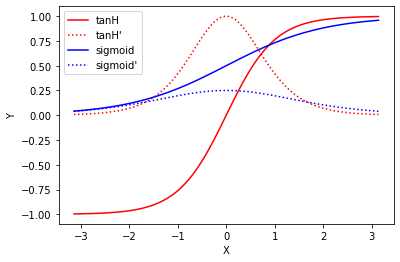

In [ ]:
in_array = np.linspace(-np.pi, np.pi, 120) 

tan_h = np.tanh(in_array) 
sig = sigmoid(in_array)  
 
plt.plot(in_array, tan_h, color = 'red', label='tanH')
plt.plot(in_array, 1-tan_h**2, linestyle=':', color = 'red', label="tanH'")
plt.plot(in_array, sig, color = 'blue', label='sigmoid')
plt.plot(in_array, sig*(1-sig), linestyle=':', color = 'blue',  label="sigmoid'")
plt.xlabel("X") 
plt.ylabel("Y") 
plt.legend(loc='best')
plt.show();